In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import itertools
import math

import datetime
from dateutil.rrule import rrule, MONTHLY

import sqlalchemy
import pgspecial

from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.metrics import adjusted_rand_score,rand_score
from pathlib import PosixPath
import joblib

from features import * 

## Calcul de l'ARI

In [68]:

date_to_str = lambda d : str(d)[:11]
date_gen = lambda dates: list(map(lambda t:  date_to_str(t[1]) ,dates))

cluster_stat = lambda  title,clusterings: print(f"{title} - Size: {len(clusterings)} - Stats:{ ({k:len(clusterings[clusterings == k]) for k in np.unique(clusterings)}) }") 

def ARI_evolution(pipe,dfs):
    """
      Calcul de l'ARI pour le traitement pipe avec les data frames dfs
    """
    prev_df = None
    ARIs = []
    for cur_df in dfs:
        if prev_df is None:
            pipe.fit_predict(cur_df)
        else:
            prev = pipe.predict(cur_df)
            cur  = pipe.fit_predict(cur_df)
            #print("==>")
            #cluster_stat("prev",prev)
            #cluster_stat("cur",cur)
            ARIs.append(
                [
                    adjusted_rand_score(prev,cur),
                    len(prev_df),
                    len(cur_df),
                    len(prev_df.index.intersection(cur_df.index))
                ]
            )
        prev_df = cur_df
    return ARIs

def files_gen(root):
    """
        génération des chemins des couples de fichiers à partir du chemin root    
    """
    extract_num = lambda stem : int(stem.replace('olist_',''))
    return [
            (
                [ dir.joinpath(f'{stem}.csv') for  stem in sorted([f.stem for f in dir.glob('*.csv')],key=extract_num) ],
                [ dir.joinpath(f'{stem}.json') for stem in sorted([f.stem for f in dir.glob('*.csv')],key=extract_num) ]
            )
            for dir in [ p  
                for r in PosixPath(root).iterdir() if r.is_dir() # and r.stem == '6'
                for p in r.iterdir() if p.is_dir() # and p.stem == '6'
            ]
        ]

def maintenance_dfs(m_files):
    """ lecture des data frames"""
    return [pd.read_csv(m_file,index_col='c_customer_unique_id') for m_file in m_files]

def meta_dfs(files):
    """ lecture des fichiers de meta données"""
    return [ pd.read_json(file) for file in files]
          

def compute_ARI_evolution(root,pipe):
 
    """
      main entry point for computing ARI evolution
      root : directory where to find dfs
      pipe : pipe to be evaluated
    """
    df_select = lambda dfs,j : map(lambda df: df.iloc[0,j],dfs)

    aris = []
    for (files,metas) in [ (files,meta_dfs(meta_files[1:])) for (files,meta_files) in files_gen(root)]:
    #for (files,meta_files) in files_gen(root):
    #    metas = meta_dfs(meta_files[1:])
    #    print(list(df_select(metas,0)))
        aris.extend(
            list(
                map(
                    lambda t: t[0] + [t[1]] + [t[2]] + [t[3]],
                    zip(
                        ARI_evolution(
                            pipe,
                            maintenance_dfs(files)
                        )
                        ,
                        df_select(metas,0)
                        ,
                        df_select(metas,2)
                        ,
                        df_select(metas,3)
                    )
                )
            )
        )

    return (
        aris
    ,
        ['ARI','size_N-1','size_N','size_common','date','freq','depth']
    )

def make_df(t):
    tmp = pd.DataFrame(data=t[0],columns=t[1])
    tmp['date'] = pd.to_datetime(tmp['date'], format='%Y-%m-%d')
    return tmp

## Chargement modèle

In [69]:

pipe = joblib.load(r'./results/model.sav')
root = r'/home/benj/Documents/code/OCR/projects/P4/data/dfs/maintenance'
ari_evolutions = make_df(
    compute_ARI_evolution(root,pipe)
)

## Affichage de l'évolution de l'ARI

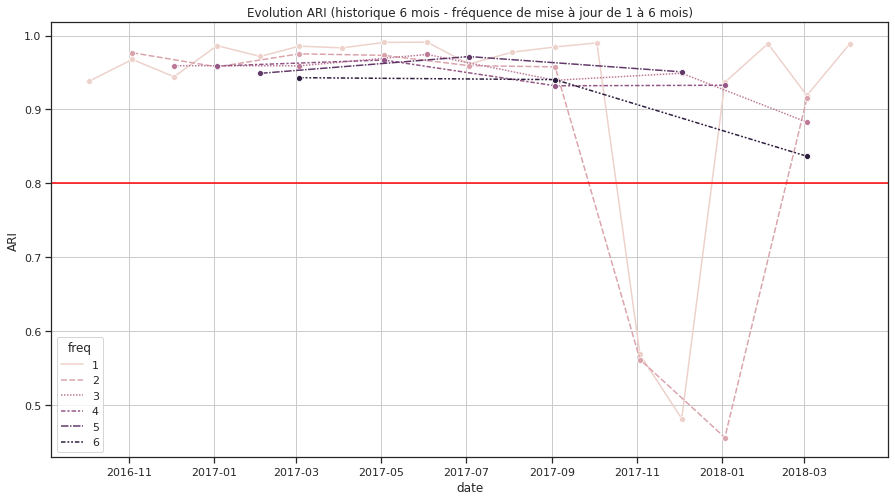

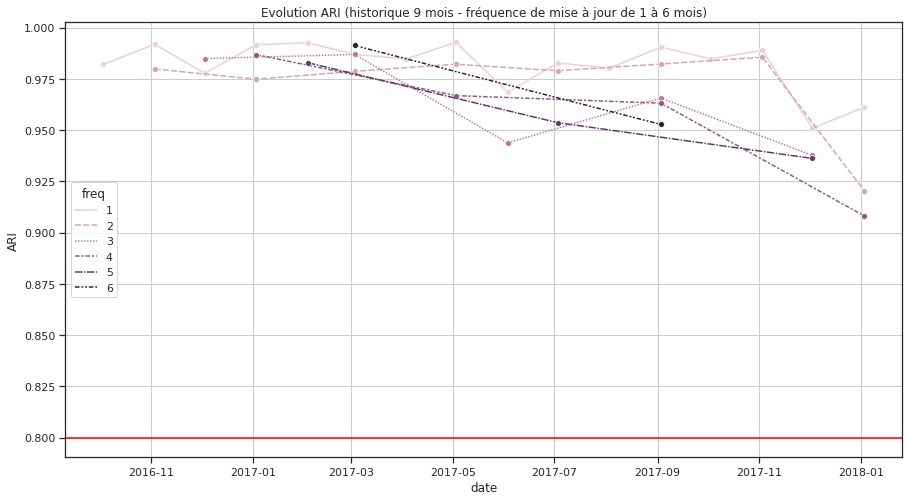

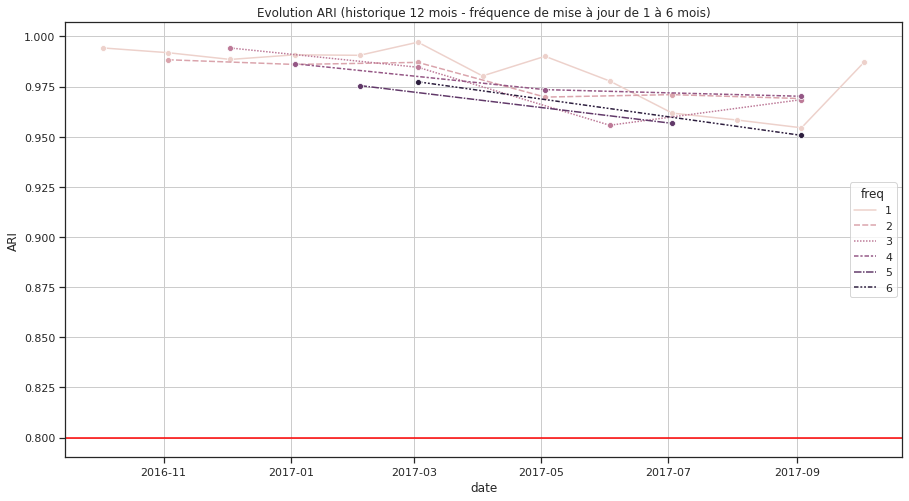

In [94]:
def plot_ari(depth):
    fig,ax = plt.subplots()
    fig.set_size_inches((15,8))
    sns.lineplot(data=ari_evolutions[ari_evolutions['depth'] == depth],x='date',y='ARI',hue='freq',style='freq',marker='o',ax=ax)
    #ax.grid()
    ax.set_title(f"Evolution ARI (historique {depth} mois - fréquence de mise à jour de 1 à 6 mois)")
    ax.axhline(0.8,color='red')

#sns.set_theme(palette='dark')
sns.set_style("ticks",{'axes.grid' : True})
for depth in [6,9,12]:
    plot_ari(depth)